# Bitcoin Stock price Prediction using LSTM

# 1. Importing Library

In [1]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# 2. Loading Dataset

#  [We can use this link to download bitcoin dataset from yahoo finance](https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD)

In [2]:
# Load our dataset 
# Note it should be in same dir


maindf=pd.read_csv('../input/datamine-1/BTC-USD3.csv')

In [3]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2923
Total number of fields present in the dataset:  7


In [4]:
maindf.shape

(2923, 7)

In [5]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-11-04,327.161011,331.766998,325.076996,330.492004,330.492004,15655500
1,2014-11-05,330.683014,343.368988,330.683014,339.485992,339.485992,19817200
2,2014-11-06,339.458008,352.966003,338.424011,349.290009,349.290009,18797000
3,2014-11-07,349.817993,352.731995,341.776001,342.415009,342.415009,16834200
4,2014-11-08,342.153992,347.032013,342.153992,345.488007,345.488007,8535470


In [6]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2918,2022-10-31,20633.695313,20795.320313,20287.458984,20495.773438,20495.773438,45668466815
2919,2022-11-01,20494.898438,20647.289063,20359.845703,20485.273438,20485.273438,39819303159
2920,2022-11-02,20482.958984,20742.810547,20087.134766,20159.503906,20159.503906,55552169483
2921,2022-11-03,20162.689453,20382.095703,20086.240234,20209.988281,20209.988281,43228750179
2922,2022-11-04,20210.894531,21208.203125,20198.378906,21164.212891,21164.212891,53984907264


In [7]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2923 entries, 0 to 2922
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2923 non-null   object 
 1   Open       2923 non-null   float64
 2   High       2923 non-null   float64
 3   Low        2923 non-null   float64
 4   Close      2923 non-null   float64
 5   Adj Close  2923 non-null   float64
 6   Volume     2923 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 160.0+ KB


In [8]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2.923000e+03
mean,12980.153602,13311.931830,12610.265542,12985.721718,12985.721718,1.639222e+10
std,16388.747712,16809.328504,15902.150849,16384.165547,16384.165547,1.995408e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,6.491650e+06
25%,710.280518,719.359985,700.619995,711.570496,711.570496,1.110510e+08
50%,7051.750000,7266.639648,6835.502930,7068.479980,7068.479980,7.280280e+09
75%,16499.750000,17540.799805,15837.120118,16566.700196,16566.700196,2.821345e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [9]:
maindf.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999516,0.999098,0.998786,0.998786,0.720441
High,0.999516,1.000000,0.999019,0.999462,0.999462,0.724249
Low,0.999098,0.999019,1.000000,0.999372,0.999372,0.712473
Close,0.998786,0.999462,0.999372,1.000000,1.000000,0.719221
Adj Close,0.998786,0.999462,0.999372,1.000000,1.000000,0.719221
Volume,0.720441,0.724249,0.712473,0.719221,0.719221,1.000000


# Checking for Null Values

In [10]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [11]:
print('NA values:',maindf.isnull().values.any())

NA values: False


In [12]:
# If dataset had null values we can use this code to drop all the null values present in the dataset

# maindf=maindf.dropna()
# print('Null Values:',maindf.isnull().values.sum())
# print('NA values:',maindf.isnull().values.any())

In [13]:
# Final shape of the dataset after dealing with null values 

maindf.shape

(2923, 7)

# 3. EDA(Exploratory Data Analysis)

In [14]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-11-04
Ending Date 2022-11-04


#### StockPrice Analysis from Start

In [15]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2014 = maindf.loc[(maindf['Date'] >= '2014-11-04')
                     & (maindf['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-11-04,327.161011,331.766998,325.076996,330.492004
1,2014-11-05,330.683014,343.368988,330.683014,339.485992
2,2014-11-06,339.458008,352.966003,338.424011,349.290009
3,2014-11-07,349.817993,352.731995,341.776001,342.415009
4,2014-11-08,342.153992,347.032013,342.153992,345.488007
5,2014-11-09,345.376007,363.626007,344.255005,363.264008
6,2014-11-10,362.265015,374.816010,357.561005,366.924011
7,2014-11-11,365.856995,371.309998,363.734985,367.695007
8,2014-11-12,367.984985,429.717987,367.984985,423.561005
9,2014-11-13,427.273010,457.092987,401.122986,420.734985


In [16]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,NaN,NaN


 Note that we only have few months in 2014 so the rest of the months are **NaN**

In [17]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Note that we only have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [18]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

Note that we only have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [19]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'], 
                                          y_2014['High'], y_2014['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2015

In [20]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2016-01-01')]

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
58,2015-01-01,320.434998,320.434998,314.002991,314.248993
59,2015-01-02,314.079010,315.838989,313.565002,315.032013
60,2015-01-03,314.846008,315.149994,281.082001,281.082001
61,2015-01-04,281.145996,287.230011,257.612000,264.195007
62,2015-01-05,265.084015,278.341003,265.084015,274.473999
...,...,...,...,...,...
418,2015-12-27,416.514008,424.006989,408.882996,422.822998
419,2015-12-28,423.342987,429.769012,418.480988,422.278992
420,2015-12-29,422.097992,432.983002,420.627014,432.983002
421,2015-12-30,433.299988,434.386993,422.084015,426.619995


In [21]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,251.799905,248.782547
February,232.821856,234.153645
March,269.278419,269.042259
April,235.708667,235.491534
May,237.161806,236.997001
June,236.941433,238.081766
July,278.857679,279.563740
August,252.986774,250.733805
September,233.486733,233.595533


In [22]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [23]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [24]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2016

In [25]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2016 = maindf.loc[(maindf['Date'] >= '2016-01-01')
                     & (maindf['Date'] < '2017-01-01')]

y_2016.drop(y_2016[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
423,2016-01-01,430.721008,436.246002,427.515015,434.334015
424,2016-01-02,434.622009,436.062012,431.869995,433.437988
425,2016-01-03,433.578003,433.743011,424.705994,430.010986
426,2016-01-04,430.061005,434.516998,429.084015,433.091003
427,2016-01-05,433.069000,434.182007,429.675995,431.959991
...,...,...,...,...,...
784,2016-12-27,908.354004,940.047974,904.255005,933.197998
785,2016-12-28,934.830994,975.921021,934.830994,975.921021
786,2016-12-29,975.125000,979.396973,954.502991,973.497009
787,2016-12-30,972.534973,972.534973,934.833008,961.237976


In [26]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,412.805902,410.844485
February,402.304692,404.408274
March,417.262033,416.525774
April,433.487433,434.339398
May,459.237547,461.954415
June,638.544834,642.869061
July,662.977779,661.356103
August,581.238966,579.585197
September,604.614034,605.848633


In [27]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [28]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [29]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'], 
                                          y_2016['High'], y_2016['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2017

In [30]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2017 = maindf.loc[(maindf['Date'] >= '2017-01-01')
                     & (maindf['Date'] < '2018-01-01')]

y_2017.drop(y_2017[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
789,2017-01-01,963.658020,1003.080017,958.698975,998.325012
790,2017-01-02,998.617004,1031.390015,996.702026,1021.750000
791,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966
792,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980
793,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005
...,...,...,...,...,...
1149,2017-12-27,16163.500000,16930.900391,15114.299805,15838.500000
1150,2017-12-28,15864.099609,15888.400391,13937.299805,14606.500000
1151,2017-12-29,14695.799805,15279.000000,14307.000000,14656.200195
1152,2017-12-30,14681.900391,14681.900391,12350.099609,12952.200195


In [31]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,914.680971,914.916159
February,1055.620071,1062.533672
March,1133.212576,1129.365228
April,1197.646997,1206.641007
May,1865.748712,1895.383529
June,2630.573332,2636.204346
July,2509.213233,2519.418386
August,3819.812579,3880.989998
September,4077.400993,4064.836312


In [32]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [33]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [34]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'], 
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2018

In [35]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2018 = maindf.loc[(maindf['Date'] >= '2018-01-01')
                     & (maindf['Date'] < '2019-01-01')]

y_2018.drop(y_2018[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1154,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
1155,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
1156,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
1157,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
1158,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...,...
1514,2018-12-27,3854.688477,3874.416992,3645.448486,3654.833496
1515,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701
1516,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691
1517,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637


In [36]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,13212.074219,13085.558090
February,9462.242920,9472.001151
March,9156.591718,9040.557097
April,7963.618311,8033.596631
May,8505.240675,8450.997732
June,6829.257975,6793.507666
July,7101.466450,7146.349987
August,6723.800955,6700.129946
September,6622.821338,6610.675033


In [37]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [38]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [39]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'], 
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2019

In [40]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1519,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020
1520,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424
1521,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211
1522,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529
1523,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580
...,...,...,...,...,...
1879,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379
1880,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234
1881,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832
1882,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117


In [41]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,3709.705645,3701.554963
February,3697.178327,3711.907261
March,3967.740400,3976.069100
April,5136.813314,5178.469434
May,7205.208024,7309.694131
June,9339.480322,9415.900179
July,10691.706055,10669.336158
August,10657.745621,10643.248362
September,9858.141813,9814.067871


In [42]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [43]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [44]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2020

In [45]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01')
                     & (maindf['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1884,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316
1885,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215
1886,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277
1887,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738
1888,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383
...,...,...,...,...,...
2245,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922
2246,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594
2247,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500
2248,2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125


In [46]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,8318.949597,8389.270476
February,9656.215113,9630.722185
March,6943.507009,6871.016113
April,7150.611328,7224.477328
May,9237.761530,9263.151745
June,9499.797005,9489.227214
July,9519.383852,9589.899729
August,11639.097215,11652.394185
September,10689.700163,10660.276856


In [47]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [48]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [49]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'], 
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2021

In [50]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01')
                     & (maindf['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2250,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
2251,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2252,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
2253,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063
2254,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
2609,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625
2610,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969
2611,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469
2612,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938


In [51]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,34652.961694,34761.649950
February,45874.967216,46306.798968
March,54544.678176,54998.008695
April,57251.256250,57206.720052
May,47105.828503,46443.286668
June,35920.546940,35845.154688
July,34234.212450,34444.973790
August,45516.119834,45709.022682
September,46041.859375,45939.771484


#### Since we had data till 24-08-2021 in Months after August its showing NaN

In [52]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [53]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [54]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [55]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01')
                     & (maindf['Date'] < '2022-11-04')]

y_2022.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2615,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500
2616,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750
2617,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188
2618,2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219
2619,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906
...,...,...,...,...,...
2917,2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516
2918,2022-10-31,20633.695313,20795.320313,20287.458984,20495.773438
2919,2022-11-01,20494.898438,20647.289063,20359.845703,20485.273438
2920,2022-11-02,20482.958984,20742.810547,20087.134766,20159.503906


In [56]:
monthvise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,41368.073463,41114.422379
February,40591.103934,40763.474051
March,41889.148438,41966.237525
April,41694.653646,41435.319662
May,31900.711127,31706.105217
June,24783.338477,24383.685482
July,21424.733052,21539.253843
August,22471.866557,22366.266318
September,19821.353711,19804.779232


In [57]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [58]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2022.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [59]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'], 
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Overall Analysis from 2014-2022

In [60]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] <= '2022-11-03')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-11-04,327.161011,331.766998,325.076996,330.492004
1,2014-11-05,330.683014,343.368988,330.683014,339.485992
2,2014-11-06,339.458008,352.966003,338.424011,349.290009
3,2014-11-07,349.817993,352.731995,341.776001,342.415009
4,2014-11-08,342.153992,347.032013,342.153992,345.488007
...,...,...,...,...,...
2917,2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516
2918,2022-10-31,20633.695313,20795.320313,20287.458984,20495.773438
2919,2022-11-01,20494.898438,20647.289063,20359.845703,20485.273438
2920,2022-11-02,20482.958984,20742.810547,20087.134766,20159.503906


In [61]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,12855.131425,12828.374881
February,13793.306352,13869.217293
March,14790.177346,14833.352724
April,15132.974493,15119.381881
May,13314.612240,13220.946305
June,11234.810040,11180.578800
July,10802.818819,10856.268967
August,12707.833563,12722.796312
September,12243.672270,12216.731369


In [62]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 4. Building LSTM Model

* ## First Step is Preparing Data for Training and Testing

* ## Here we are just considering 1 year data for training data 

* ## Since Bitcoin price has drastically flucated from 200 dollar in year 2014 to 15000 dollar in year 2018 to 3000 dollar in year 2019(theses values are apporx) so we will just consider 1 Year to avoid this type of flucation in the data.

* ## As we want to predict Close Price of the Bitcoin so we are just Considering Close aand Date  

In [63]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2923, 2)


In [64]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014-2022', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Now we will Take data of just 1 Year

In [65]:
closedf = closedf[closedf['Date'] > '2019-02-19']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1354


In [66]:
closedf

,Date,Close
1569,2019-02-20,3999.820557
1570,2019-02-21,3954.118164
1571,2019-02-22,4005.526611
1572,2019-02-23,4142.526855
1573,2019-02-24,3810.427490
...,...,...
2918,2022-10-31,20495.773438
2919,2022-11-01,20485.273438
2920,2022-11-02,20159.503906
2921,2022-11-03,20209.988281


In [67]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

* ### Normalizing Data
- Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
- MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [68]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1354, 1)


* ### Slicing data into Training set and Testing set

In [69]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1083, 1)
test_data:  (271, 1)


* ### Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15   

In [70]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [71]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1067, 15)
y_train:  (1067,)
X_test:  (255, 15)
y_test (255,)


In [72]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1067, 15, 1)
X_test:  (255, 15, 1)


* # Actuall Model Building

In [73]:
model=Sequential()

model.add(LSTM(20,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [74]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
34/34 [==============================] - 3s 31ms/step - loss: 0.1205 - val_loss: 0.0215
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0199 - val_loss: 0.0023
Epoch 3/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 4/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 5/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 7/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 7.4940e-04
Epoch 9/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 8.2471e-04
Epoch 10/200
34/34 [==============================] - 0s 9ms/step - loss: 8.5695e-04 - val_loss: 0.0

- ### Plotting Loss vs Validation loss 

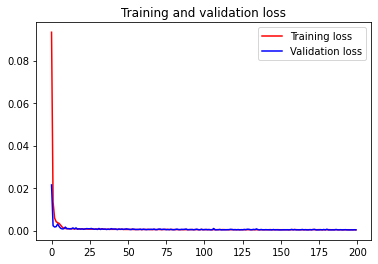

<Figure size 432x288 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [76]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((1067, 1), (255, 1))

- # Model Evaluation

In [77]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ## Evaluation metrices RMSE, MSE and MAE

In [78]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1193.123766925865
Train data MSE:  1423544.323203366
Train data MAE:  725.4558268000234
-------------------------------------------------------------------------------------
Test data RMSE:  1096.0069420977059
Test data MSE:  1201231.2171263641
Test data MAE:  766.4710937073531


- ## Variance Regression Score

In [79]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9961512966779108
Test data explained variance regression score: 0.9864834934472795


- ## R square score for regression

In [80]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9961037975706037
Test data R2 score: 0.9856591138399348


- ## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [81]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00211743399554636
Test data MGD:  0.0013863407199512223
----------------------------------------------------------------------
Train data MPD:  41.04925303469523
Test data MPD:  39.26809304170616


- # Comparision of original stock close price and predicted close price

In [82]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1354, 1)
Test predicted data:  (1354, 1)


- # Predicting next 30 days

In [83]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


- # Plotting last 15 days of dataset and next predicted 30 days

In [84]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [85]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



- # Plotting entire Closing Stock Price with next 30 days period of prediction

In [86]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False
fig.show()